## Projet M1 ML: inpainting

#### Binôme: Yuhan WANG et Tianyu WANG

### données USPS
USPS est une base de données de classification de chiffres(0-9) manuscrits.USPS_train.txt a 7291 exemplaires et 2007 test images. The images are 16*16 grayscale pixels. Chaque image est en taille 16*16, donc en total 256 parametres x et a un attribut y qui represente auquelle classe qu'elle appartient.

In [1]:
import numpy as np
import sklearn
from fonctions import *

In [2]:
X,Y=load_usps('USPS_train.txt')
x,y=load_usps('USPS_test.txt')

### Préambule: régression linéaire, régression ridge et LASSO
Dans la régression linéaire, on utilise $Mse(f_w,E)=||Xw-y||^2_2$ sous l'expression de matrice. Pour minimiser la fonction d'erreur, il faut faire la dérivation:  
    $\frac {\partial Mse(f_w , E)}{\partial w}=0-2X^Ty+2X^TXw=0 $  
    $X^TXw=2X^Ty$  
    Pour que la partie gauche ne contient que w, il faut la multiple avec $X^TX^{-1}$, qui n'existe que pour $X^TX$ invertible (qui veut dire notre probleme n'a pas de **multicolinéarité**), qui est presque impossible dans le cas réel. Régression ridge et Lasso sont crée pour résoudre le probleme en cas de multicolinéarité.

In [3]:
train_X,train_Y=X[(Y==3)|(Y==8)],Y[(Y==3)|(Y==8)]
test_x,test_y=x[(y==3)|(y==8)],y[(y==3)|(y==8)]
train_Y=np.array(np.where(train_Y==3,-1,1))
test_y=np.array(np.where(test_y==3,-1,1))

In [4]:
from sklearn import linear_model
from sklearn.metrics import r2_score
#regression lineaire:
reg=linear_model.LinearRegression()
reg.fit(train_X,train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
print(reg.score(test_x,test_y))

0.7433552383309949


### Ridge
$L_2(f_w,E)= Mse(f_w , E)+\alpha||w||^2$ où $||w||^2 = \sqrt{\sum_{i=0}^n w_i}$  
Si on reprend la dérivation:  
    $\frac{\partial L_2(f_w,E)}{\partial w}= \frac{\partial Mse(f_w , E)}{\partial w}+\frac{\partial \alpha||w||^2}{\partial w}$  
    $\frac{\partial L_2(f_w,E)}{\partial w}= X^TXw+\alpha w-X^Ty$=$(X^TX+\alpha I)w-X^Ty$ où I est **matrice identité**.  
    la dérivation=0 => $(X^TX+\alpha I)w=X^Ty$  
    On ajoute certains chiffres dans la diagonale de matrice $X^TX$ donc théoriquement, il est moins possible d'être **multicolinéarité**, et on peut le résoudre avec la régression.    
### Lasso
$L_3(f_w,E)= Mse(f_w , E)+\alpha||w||$ où $||w|| = \sum_{i=0}^n |w_i|$  
$\frac{\partial L_3(f_w,E)}{\partial w}= \frac{\partial Mse(f_w , E)}{\partial w}+\frac{\partial \alpha||w||}{\partial w}$  
$\frac{\partial L_2(f_w,E)}{\partial w}= X^TXw+\frac{\alpha I}{2}-X^Ty$ si $||w||>0$, sinon $X^TXw-\frac{\alpha I}{2}-X^Ty$  
Donc alpha dans l'algorithme Lasso peut être **négative**. En comparant avec Ridge, Lasso ne peut pas résoudre la multicolinéarité, mais il est utile dans la section de **contraction des coefficients**.


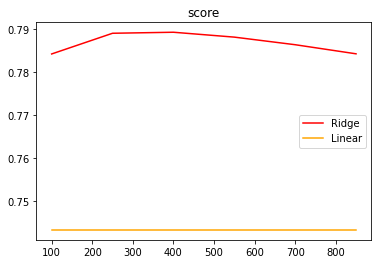

In [25]:
alpharange=np.arange(100,1000,150)
ridges,lrs=[],[]
varR,varLR=[],[]
for alpha in alpharange:
    ridge=linear_model.Ridge(alpha=alpha).fit(train_X,train_Y)
    linear=linear_model.LinearRegression().fit(train_X,train_Y)
    ridges.append(ridge.score(test_x,test_y))
    lrs.append(linear.score(test_x,test_y))
plt.plot(alpharange,ridges,color='red',label='Ridge')
plt.plot(alpharange,lrs,color='orange',label='Linear')
plt.title('score')
plt.legend()
plt.show()

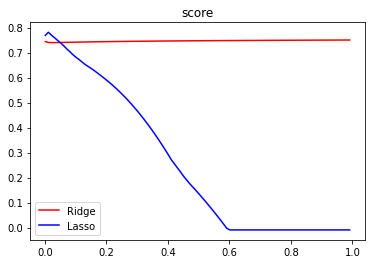

In [67]:
alpharange=np.arange(0.001,1,0.01)
ridges,lrs=[],[]
len_nonnul=[]
for alpha in alpharange:
    ridge=linear_model.Ridge(alpha=alpha).fit(train_X,train_Y)
    lasso=linear_model.Lasso(alpha=alpha).fit(train_X,train_Y)
    ridges.append(ridge.score(test_x,test_y))
    lrs.append(lasso.score(test_x,test_y))
    coef=lasso.coef_
    len_nonnul.append(len(coef[coef!=0]))
plt.plot(alpharange,ridges,color='red',label='Ridge')
plt.plot(alpharange,lrs,color='blue',label='Lasso')
plt.title('score')
plt.legend()
plt.show()

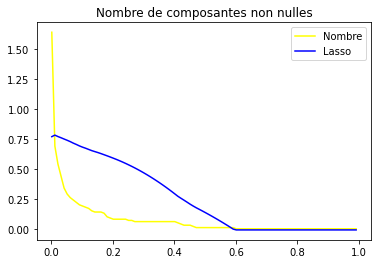

In [69]:
plt.plot(alpharange,np.array(len_nonnul)*0.01,color='yellow',label='Nombre')
plt.plot(alpharange,lrs,color='blue',label='Lasso')
plt.title('Nombre de composantes non nulles')
plt.legend()
plt.show()

### Partie II: Lasso et inpainting
De manière générale en inpainting, une hypothèse fondamentale est qu’une image a une cohérence spatiale et de texture

In [46]:
from matplotlib import colors

In [47]:
data=plt.imread("Lenna.jpg")
data=colors.rgb_to_hsv(data)

In [43]:
print(type(data))
print(data[0,0,0])

<class 'numpy.ndarray'>
225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


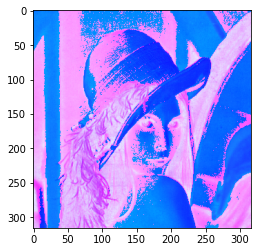

In [48]:
plt.imshow(data)